In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
import datetime as dt

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import day_of_week_translator, feriados, vesperas

In [3]:
data_2018 = pd.read_csv('./data_input_zerofill_2018.csv')
data_2015 = pd.read_csv('./data_input_zerofill_2015.csv', delimiter=';')
data_2020 = pd.read_csv('./data_input_zerofill_2020.csv', delimiter=';')

busline_filter = 41

feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

one_hot_encoder = OneHotEncoder(sparse=False)

data_2018[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_2018['d_semana'].values.reshape(-1,1))
data_2018['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_2018.d_mes, data_2018.mes))]
data_2018['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_2018.d_mes, data_2018.mes))]


data_2015[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_2015['d_semana'].values.reshape(-1,1))
data_2015['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_2015.d_mes, data_2015.mes))]
data_2015['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_2015.d_mes, data_2015.mes))]


data_2020[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_2020['d_semana'].values.reshape(-1,1))
data_2020['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_2020.d_mes, data_2020.mes))]
data_2020['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_2020.d_mes, data_2020.mes))]
data = pd.concat([data_2015, data_2018, data_2020])



In [4]:
data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

In [5]:
data

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
0,1,2015-01-15 02:00:00,0,3,0.519584,0.854419,2,15,15,1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
1,1,2015-01-25 02:00:00,0,6,0.519584,0.854419,2,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2,1,2015-01-25 06:00:00,0,6,0.997669,-0.068242,6,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,1,2015-01-25 07:00:00,0,6,0.942261,-0.334880,7,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,1,2015-01-25 08:00:00,0,6,0.816970,-0.576680,8,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604349,999,2020-12-01 08:00:00,12,1,0.816970,-0.576680,8,1,336,12,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1604350,999,2020-12-01 09:00:00,1,1,0.631088,-0.775711,9,1,336,12,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1604351,999,2020-12-01 10:00:00,1,1,0.398401,-0.917211,10,1,336,12,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1604352,999,2020-12-01 11:00:00,5,1,0.136167,-0.990686,11,1,336,12,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0


range(1, 13)

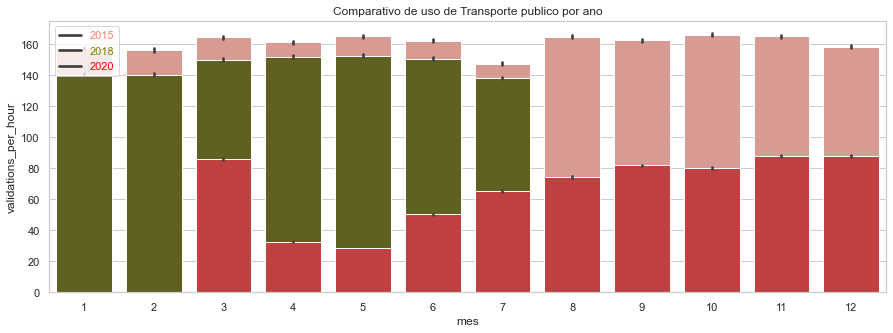

In [17]:
fig = plt.figure(figsize=(15,5))
plt.xlabel('Meses')
plt.ylabel('Quantidade Valid.')
plt.title("Comparativo de uso de Transporte publico por ano")
sns.set_theme(style="whitegrid")
sns.barplot(x="mes", y="validations_per_hour", data=data.loc[data.data_hora.dt.year == 2015], color='salmon', saturation=.5)
sns.barplot(x="mes", y="validations_per_hour", data=data.loc[data.data_hora.dt.year == 2018], color='olive', saturation=.5)
sns.barplot(x="mes", y="validations_per_hour", data=data.loc[data.data_hora.dt.year == 2020], color='red', saturation=.5)
plt.legend(['2015', '2018', '2020'], loc="upper left", labelcolor=['salmon', 'olive', 'red'])
plt.savefig('./images/comparativo_anos_qtd_meses.pdf')
plt.show()

In [20]:
data_model = data.reset_index(drop=True).copy()

top100_linhas = data_model.linha.value_counts().index[:100]
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)].loc[data['mes']]

top100_linhas_data_model.to_csv("./dados-para-modelos/2015+2018/top100_linhas_data_model_2015+2018.csv", index=False)


line_data_model = data_model.loc[data_model['linha'] == busline_filter].copy()

X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

model_list = []

def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [21]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

In [22]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)

performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['Regressao Linear Default', 'RandomForest Default', 'Regressao Linear Grid Searched', 'RandomForest GridSearched'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 673,
 'n_jobs': 6}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': False}

----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.4531715836817255, 308.4180539486735, 235.04814038607336, 1.1669137932438665e+19]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.8863587935032327, 140.59898096615595, 79.78174160344557, 2.666134529538175e+18]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.4531715836817255, 308.4180539486735, 235.04814038607336, 1.1669137932438665e+19]

----------------------------------------------------

Random Fores

In [23]:
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(LinearRegression())
RandomForestModelPipeline = make_pipeline(RandomForestRegressor())


bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Regressao Linear Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)

gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])

Performance for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = [0.4534516442175346, 308.33906501437315, 234.805162700576, 1.1609712824762022e+19]

Performance for base estimator Pipeline(steps=[('randomforestregressor', RandomForestRegressor())]) = [0.8928817248416999, 136.50420832451894, 78.14902799997833, 2.7692190972303186e+18]



In [24]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline), 
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=DefaultRandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

In [25]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     #default_linearregression_model,
#     #gridsearched_result_linearregression,
#     #gridsearched_random_randomforest,
#     #bagging_lr_model,
# ]

sample = X.sample(n=1)
sample

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

display(data_model.loc[sample.index[0]:sample.index[0]])

res = stack.predict(sample)
print("Stacked Regressor -> resultado do predict de test: ", res)

res = gradient_boosting_regressor.predict(sample)
print("gradient_boosting_regressor -> resultado do predict de test: ", res)

res = bagging_rf_model.predict(sample)
print("bagging_rf_model -> resultado do predict de test: ", res)

res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", res)

res = default_randomforest_model.predict(sample)
print("Random Forest Default -> resultado do predict de test: ", res)

res = bagging_lr_model.predict(sample)
print("bagging_lr_model -> resultado do predict de test: ", res)

res = default_linearregression_model.predict(sample)
print("Regressao Linear Default -> resultado do predict de test: ", res)

res = gridsearched_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", res)

LINHA UTILIZADA PARA OS TESTES:  41

Utilizando sample aleatorio de dado para teste de previsao: 


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2215760,41,2018-06-02 04:00:00,42,5,0.887885,0.460065,4,2,153,6,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


Stacked Regressor -> resultado do predict de test:  [39.23]
gradient_boosting_regressor -> resultado do predict de test:  [31.32471473]
bagging_rf_model -> resultado do predict de test:  [32.252]
Random Forest Best Grid Searched -> resultado do predict de test:  [52.30770183]
Random Forest Default -> resultado do predict de test:  [37.92]
bagging_lr_model -> resultado do predict de test:  [203.23635128]
Regressao Linear Default -> resultado do predict de test:  [203.61157283]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [203.61157283]


In [26]:
performance_total.sort_values('MAE', ascending=True)

,R2,RMSE,MAE,MAPE
Stacking Regressors,0.958197,85.273933,54.075832,6.054714e+17
GradientBoostingRegressor,0.941530,100.851385,65.036494,3.172326e+18
RandomForest Bagging,0.892882,136.504208,78.149028,2.769219e+18
RandomForest GridSearched,0.904882,128.631055,79.623176,2.544985e+18
RandomForest Default,0.886359,140.598981,79.781742,2.666135e+18
Regressao Linear Bagging,0.453452,308.339065,234.805163,1.160971e+19
Regressao Linear Default,0.453172,308.418054,235.048140,1.166914e+19
Regressao Linear Grid Searched,0.453172,308.418054,235.048140,1.166914e+19


In [27]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest,
    #default_linearregression_model,
    #gridsearch_result_linearregression,
    #bagging_lr_model,
]

In [28]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

mes_de_treino = 3
mes_de_previsao = 4

line_mes_data_model = line_data_model[line_data_model.mes == mes_de_treino]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[],[]]
performances = list()

for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])

df_performance = pd.DataFrame(performances)
# df_performance.to_csv('./performances/2015/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_performance.csv', index=False)
df_predict_dados = real_values
df_predict_dados['validations_per_hour_predicted'] = predictions[0]

# df_predict_dados.to_csv('./predict-vs-real/2015/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_predict.csv', index=False)
df_predict_dados

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,validations_per_hour,validations_per_hour_predicted
230684,0,0.49
230685,0,0.21
230686,0,0.21
230687,0,1.40
230688,0,0.21
...,...,...
2214610,352,357.92
2214611,287,407.16
2214612,239,284.42
2214613,161,207.43


In [29]:
predictions = []
performances = [[],[],[],[],[],[],[],[]]

df_treinamento = line_data_model[line_data_model.mes < 6].copy()
df_previsao = line_data_model[line_data_model.mes == 6].loc[line_data_model.d_mes < 8].copy()
df_prev = df_previsao.filter(feature_names, axis = 1)
df_results = df_previsao.filter('validations_per_hour', axis = 1)

print(df_results.__len__())

X = df_treinamento.filter(feature_names, axis=1)
y = df_treinamento.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


stack.fit(X_train, Y_train)
# performances[i].append(get_performance(stack))

for index, row in df_prev.iterrows():
    predictions.append(stack.predict([row])[0])

df_results = df_previsao.validations_per_hour

df_performance = pd.DataFrame(performances)
df_performance.to_csv('./performances/2015+2018/performance_9_meses_predict_10th_stacking.csv', index=False)


359


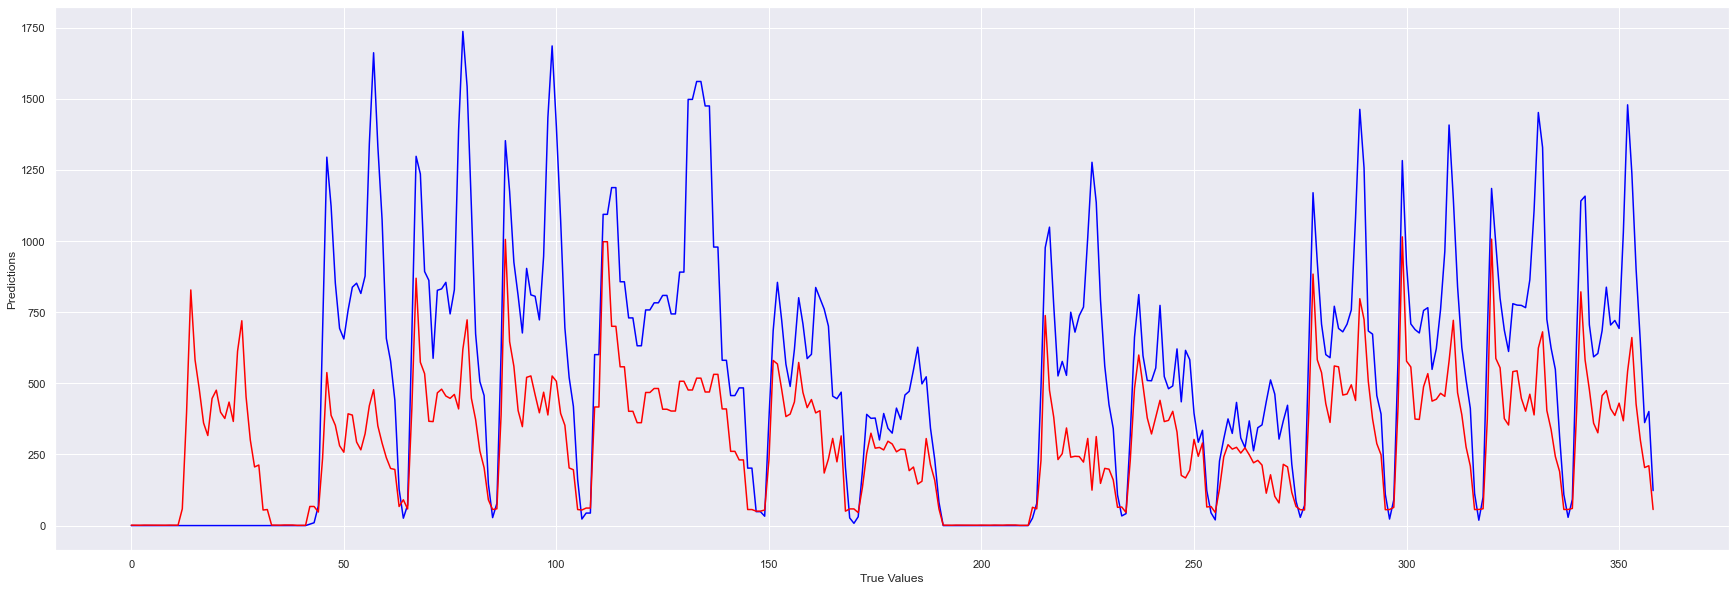

In [30]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168

plt.figure(figsize=(30, 10))
plt.plot(range(df_results.size), df_results.values, color='blue')
plt.plot(range(predictions.__len__()), predictions, color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()